In [1]:
import torch
%cd ..
# Datamodule Usage Demo
import dotenv

dotenv.load_dotenv()

/home/paulw/projects/SSLmicroUltrasound


True

## Datamodule

In [2]:
from exactvu.data.datamodule import ExactSSLDataModule

dm = ExactSSLDataModule(
    mode="self-supervised",
    prostate_region_only=False,
    needle_region_only=False,
    patch_stride_mm=(1,1),
    cohort_specifier="UVA600",
    return_metadata=True
)
dm.setup()

100%|██████████| 100/100 [00:00<00:00, 134.16it/s]


{'patient_id': 47, 'path_on_server': '/med-i_data/Data/Exact_Ultrasound/data/full_data/Benign/UVA-0047_RBL_Benign.mat', 'center': 'UVA', 'loc': 'RBL', 'grade': 'Benign', 'age': 56, 'family_history': True, 'psa': 4.01, 'pct_cancer': nan, 'primary_grade': nan, 'secondary_grade': nan, 'patient_specifier': 'UVA-0047', 'core_specifier': 'UVA-0047_RBL'}


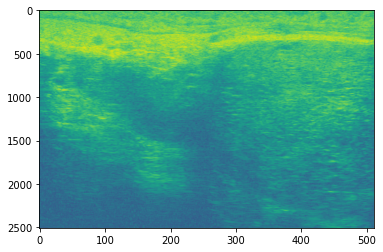

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from exactvu.data.transforms import Transform

core_idx = 1

test_ds = dm.test_ds
_core = test_ds.cores[core_idx]
_core_data = test_ds.core_data[core_idx]
print(_core.metadata)

_core.download_bmode()
_bmode = _core.bmode
_bmode = (_bmode-np.min(_bmode,keepdims=True))/(np.max(_bmode)-np.min(_bmode))
_prst_mask = _core.prostate_mask

_transform = Transform(use_augmentations=False, prob=0.0)
_patch = _transform(torch.tensor(_core_data[0][0]))

plt.imshow(_bmode, aspect='auto')
# plt.imshow(_prst_mask, 'gray')
# plt.imshow(_patch[0,...], 'gray', aspect='auto')

## Neural model

In [5]:
from src.models.supervised.test_module import ExacTestFinetuner
from src.models.self_supervised.finetuner_module import ExactFineTuner
from src.models.self_supervised.vicreg.vicreg_module import VICReg

network_ckpt_path = "./logs/experiments/runs/fintunUVA600_ckpt/2022-08-30_10-10-58/checkpoints/epoch_011.ckpt" #26
model = ExacTestFinetuner(test_module=ExactFineTuner(backbone=VICReg, semi_sup=True), ckpt_path=network_ckpt_path)
model.eval()

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(
/home/paulw/projects/SSLmicroUltrasound/src/models/self_supervised/finetuner_module.py:64: UserWarning: You are using the finetuner model with no loadable checkpoint. The model will be randomly initialized.
  warn(
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'test_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_module'])`.
  rank_zero_warn(
/home/paulw/projects/SSLmicroUltrasound/src/models/self_supervised/exact_ssl_module.py:147: UserWarning: Using scheduler_interval=step might generate issues when resuming a checkpoint.
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/home/paulw/projects/SSLmicroUltrasound/./logs/experiments/runs/fintunUVA600_ckpt/2022-08-30_10-10-58/checkpoints/epoch_011.ckpt'

In [107]:
predictions = []
for i in range(len(_core_data)):
    _patch = _transform(torch.tensor(_core_data[i][0])).unsqueeze(0)
    _repres = model.test_module.backbone(_patch)["feats"]
    _repres = _repres.view(_repres.size(0), -1)
    _pred = model.test_module.linear_layer(_repres)
    predictions.append(_pred)
predictions = torch.cat(predictions)

In [113]:
positions = []
for i in range(len(_core_data)):
    positions.append(_core_data[i][1])

## Heatmap

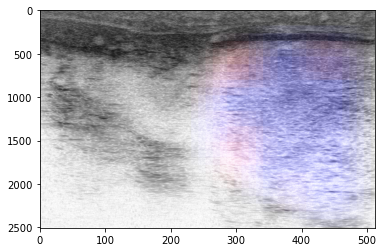

array([[[0.43502457, 0.43502457, 0.43502457],
        [0.51890404, 0.51890404, 0.51890404],
        [0.48843955, 0.48843955, 0.48843955],
        ...,
        [0.46737135, 0.46737135, 0.46737135],
        [0.51326024, 0.51326024, 0.51326024],
        [0.45838033, 0.45838033, 0.45838033]],

       [[0.55227141, 0.55227141, 0.55227141],
        [0.67836856, 0.67836856, 0.67836856],
        [0.53481425, 0.53481425, 0.53481425],
        ...,
        [0.45356647, 0.45356647, 0.45356647],
        [0.4795078 , 0.4795078 , 0.4795078 ],
        [0.5734223 , 0.5734223 , 0.5734223 ]],

       [[0.39294315, 0.39294315, 0.39294315],
        [0.47942626, 0.47942626, 0.47942626],
        [0.40230945, 0.40230945, 0.40230945],
        ...,
        [0.39379085, 0.39379085, 0.39379085],
        [0.39151462, 0.39151462, 0.39151462],
        [0.3666981 , 0.3666981 , 0.3666981 ]],

       ...,

       [[0.91679153, 0.91679153, 0.91679153],
        [0.94498995, 0.94498995, 0.94498995],
        [1.00173802, 1

In [172]:
import numpy as np
import math
from skimage.transform import resize

def plot_heatmap(bmode, prst_mask, predictions, patch_positions,  pred_transp=0.02, bmode_transp=.7):
    bmode_copy = bmode_transp*np.copy(bmode)
    # bmode_copy = np.zeros_like(bmode_copy)

    axial_mm = 28
    lateral_mm = 46
    patch_size = (5,5)

    mm_to_pixel_axial = math.floor(bmode_copy.shape[0]/axial_mm)
    mm_to_pixel_lateral = math.floor(bmode_copy.shape[1]/lateral_mm)
    transp = pred_transp

    red_patch = np.zeros((5*mm_to_pixel_axial,5*mm_to_pixel_lateral,3), dtype=float)
    red_patch[:,:,0] = transp*np.ones((5*mm_to_pixel_axial,5*mm_to_pixel_lateral), dtype=float)

    blue_patch = np.zeros((5*mm_to_pixel_axial,5*mm_to_pixel_lateral,3), dtype=float)
    blue_patch[:,:,2] = transp*np.ones((5*mm_to_pixel_axial,5*mm_to_pixel_lateral), dtype=float)

    for i in range(len(predictions)):
        pred_patch = red_patch if predictions[i]>0 else blue_patch

        u_pos = math.floor(patch_positions[i][0]*mm_to_pixel_axial)
        d_pos = math.floor(patch_positions[i][1]*mm_to_pixel_axial)
        l_pos = math.floor(patch_positions[i][2]*mm_to_pixel_lateral)
        r_pos = math.floor(patch_positions[i][3]*mm_to_pixel_lateral)


        if prst_mask[math.floor((u_pos+d_pos)/2.),math.floor((l_pos+r_pos)/2.)]:
            bmode_copy[u_pos:d_pos, l_pos:r_pos] += pred_patch

    plt.imshow(bmode_copy, aspect='auto')
    plt.show()

    return bmode_copy

_bmode_rgb = np.zeros((_bmode.shape[0],_bmode.shape[1],3))
_bmode_rgb[:,:,0] = 1. - _bmode
_bmode_rgb[:,:,1] = 1. - _bmode
_bmode_rgb[:,:,2] = 1. - _bmode

_prst_mask = resize(_prst_mask, (_bmode.shape[0],_bmode.shape[1]))
# plt.imshow(_prst_mask, aspect='auto')
plot_heatmap(_bmode_rgb, _prst_mask, torch.argmax(predictions,1), positions, pred_transp=0.01, bmode_transp=1.5)